In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Higher-order Accurate ODE Integration

We'll continue to work on the orbit problem, so let's define our RHS.

In [7]:
G = 4*np.pi**2
M_sun = 1.0

def rhs(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy
    
    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([xdot, ydot, vxdot, vydot])

We'll also define our `OrbitHistory` class again, this time adding a method to return the error we explored previously.

In [16]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])
        
    def error_radius(self):
        """return the difference in the distance from the Sun"""
        R_orig = np.sqrt(self.x[0]**2 + self.y[0]**2)
        R_new = np.sqrt(self.x[-1]**2 + self.y[-1]**2)
        return np.abs(R_new - R_orig)        

    def error_position(self):
        """return the difference in the distance from the Sun"""
        dx = self.x[0] - self.x[-1]
        dy = self.y[0] - self.y[-1]
        return np.sqrt(dx**2 + dy**2)


## 2nd-order Runge Kutta / Midpoint method

The Euler method was based on a first-order difference approximation to the derivative.  But we know that a centered-derivative is second order accurate, so we can try to update our system in the form:

$$\frac{{\bf r}^{n+1} - {\bf r}^n}{\tau} = {\bf v}^{n+1/2} + \mathcal{O}(\tau^2)$$

$$\frac{{\bf v}^{n+1} - {\bf v}^n}{\tau} = {\bf a}^{n+1/2} + \mathcal{O}(\tau^2)$$

Then the updates are:

$${\bf r}^{n+1} = {\bf r}^n + \tau \, {\bf v}^{n+1/2} + \mathcal{O}(\tau^3)$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}^{n+1/2} + \mathcal{O}(\tau^3)$$

This is locally third-order accurate (but globally second-order accurate), but we don't know how to compute the state at the half-time.

To find the $n+1/2$ state, we first use Euler's method to predict the state at the midpoint in time.  We then use this provisional state to evaluate the accelerations at the midpoint and use those to update the state fully through $\tau$.  

The two step process appears as:

$${\bf r}^\star = {\bf r}^n + (\tau / 2) {\bf v}^n$$

$${\bf v}^\star = {\bf v}^n + (\tau / 2) {\bf a}^n$$

then we use this for the full update:

$${\bf r}^{n+1} = {\bf r}^n + \tau \,  {\bf v}^\star$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}({\bf r}^\star)$$

Graphically this looks like the following:

First we take a half step and we evaluate the slope at the midpoint:

![RK2 half step](rk2_halfEuler.png)

Then we go back to $t^n$ but follow the slope we found above all the way to $t^{n+1}$:

![RK2 final](rk2_final.png)

Notice how the final step (the red line) is parallel to the slope we computed at $t^{n+1/2}$.  Also note that the solution at $t^{n+1}$ is much closer to the analytic solution than in the figure from Euler's method.

Let's see how this method does with the orbit problem.

In [9]:
def euler_rk2(Y0, tau, T):

    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Ydot = rhs(t, Y)
    
        # predict the state at the midpoint
        Ytmp = Y + 0.5 * tau * Ydot
        
        # evaluate the RHS at the midpoint
        Ydot = rhs(t + 0.5*tau, Ytmp)
        
        # do the final update
        Y += tau * Ydot
        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
 

Setup our initial conditions as before with Earth on the +y axis and a counterclockwise circular velocity.

In [10]:
T = 1
x0 = 0
y0 = 1
vx0 = -np.sqrt(G*M_sun/y0)
vy0 = 0

Y0 = np.array([x0, y0, vx0, vy0])

tau = 1.0/12.0

orbit = euler_rk2(Y0, tau, 1)

Let's plot our orbit

In [1]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

# draw the orbit
ax.plot(orbit.x, orbit.y)

ax.set_aspect("equal")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

NameError: name 'plt' is not defined

This is substantially better than the first-order Euler method.  Now let's look at a range of timesteps.

Text(0, 0.5, 'y [AU]')

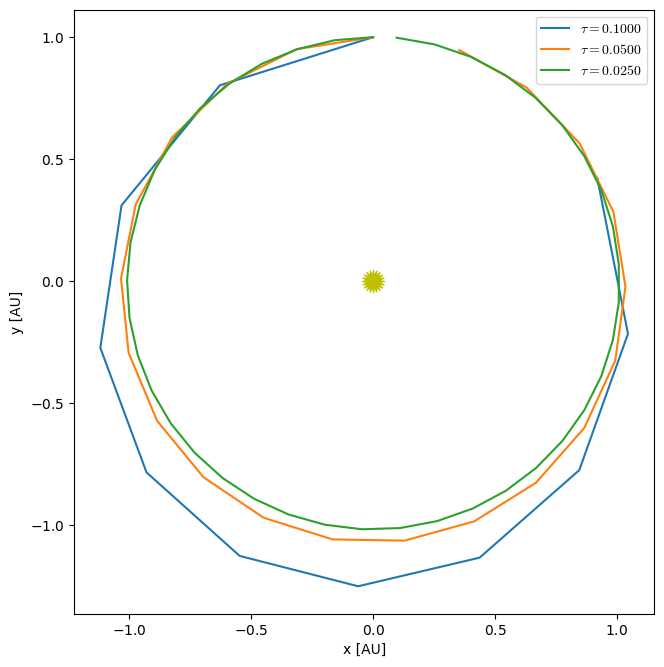

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

taus = [0.1, 0.05, 0.025]

for tau in taus:
    orbit = euler_rk2(Y0, tau, 1)
    
    ax.plot(orbit.x, orbit.y, label=rf"$\tau = {tau:6.4f}$")

ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

and how does the error converge?

In [24]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
    o = euler_rk2(Y0, tau, 1)
    print(f"tau = {tau}, error = {o.error_radius()} {o.error_position()}")

tau = 0.1, error = 0.011600055274576526 1.08559003010644
tau = 0.05, error = 0.011122662272447181 0.35694171496532084
tau = 0.025, error = 0.0024708535489856853 0.09666868480861457
tau = 0.0125, error = 0.0003606860353677632 0.023906400259474197
tau = 0.00625, error = 4.692610158629762e-05 0.0058463428972516706


Notice that once we get past the first, very coarse $\tau$, the errors seem to decrease by a factor of 4 when we halve the timestep&mdash;as we'd expect for a 2nd order accurate method. (Actually, it looks like the measure of radius converges better than position).

## 4th-order Runge-Kutta

Now we consider a 4th order accurate method&mdash;4th order Runge-Kutta (RK4).  For many problems, this method will work very well and as a result, RK4 is widely used.

We'll consider a general system of first order differential equations:

$$\dot{\bf y} = {\bf f}({\bf y})$$

The advance begins by estimating the derivatives (righthand side or slope) at time $t^n$.  We'll call this ${\bf k}_1$.

![4th order Runge-Kutta k1](rk4_k1.png)

We then follow the slope ${\bf k}_1$ to the midpoint in time, $t^{n+1/2}$ and evaluate the slope there.  We call the new slope ${\bf k}_2$.

![4th order Runge-Kutta k2](rk4_k2.png)

We then go back to the start, but this time follow the new slope,
${\bf k}_2$ to the midpoint in time, $t^{n+1/2}$.  We again evaluate the slope here, and call it ${\bf k}_3$.

![4th order Runge-Kutta k3](rk4_k3.png)

Finally, we go back to the start and follow ${\bf k}_3$ for the full
timestep, to $t^{n+1}$ and evaluate the slope there, calling it ${\bf k}_4$.

![4th order Runge-Kutta k4](rk4_k4.png)

We then get the updated solution using a linear combination of the 4 slopes:

$${\bf y}^{n+1} = {\bf y}^n + \frac{\tau}{6} ({\bf k}_1 + 2 {\bf k}_2 + 2 {\bf k}_3 + {\bf k}_4)$$

![4th order Runge-Kutta final](rk4_final.png)

Note the similarity of RK4 to Simpson's rule for integration.

<div class="alert alert-block alert-info">

**Exercise:**
    
Implement RK4 as described above and use it to evolve the orbit problem and measure the convergence.

</div>

## Timestepping

In the above examples, we always kept the timestep $\tau$ fixed, but in general, finding the solution to a system of ODEs might have portions in time where the solution is changing rapidly and a smaller $\tau$ would be needed.  Likewise, is the solution is changing slowly, we can use a larger timestep.

Most ODE libraries use some form of local error estimation to measure how the large the error is in the solution and adjust the timestep (up or down) to achieve a desired accuracy.

To see why this might be needed, consider an elliptical orbit.

![elliptical orbit](ellipse_initial_cond.png)

The initial conditions for a planet at perihelion (on the +y axis) are:

$$x = 0$$

$$y = a (1 - e)$$

$$v_x = -\sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

$$v_y = 0$$

where $a$ is the length of the semi-major axis and $0 \le e < 1$ is the eccentricity.  For an eccentric orbit, the velocity changes throughout the orbit, so when the planet is at perihelion, the solution is changing rapidly.

<div class="alert alert-block alert-info">

**Exercise:**
    
Integrate an orbit with a large eccentricity (like $e = 0.8$).  Pick a timestep such that visually the orbit looks okay.  Now make a plot of the total energy per unit mass, $\mathcal{E}$ vs time:

$$\mathcal{E} = \frac{1}{2} |{\bf v}|^2 - \frac{GM_\star}{r}$$

At what point in the orbit is the energy conservation the worst?    
</div>